In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0
Running TARDIS 2.1...


Using TensorFlow backend.


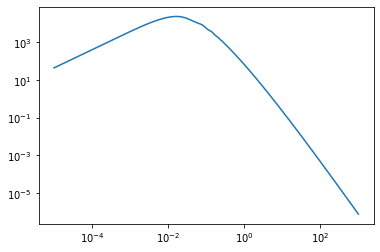

In [2]:
klin = np.loadtxt('Planck15_a1p00.txt').T[0]
plin = np.loadtxt('Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=64
uni1 = universe(bs=n, nc=n,z_f=1,ipklin = ipklin )
uni1.evolv()
flux_true1 = exp(-uni1.final_tau_RSD)[0]

(64, 64, 64)
262144 65 262144
Total run time 3.4534974098205566


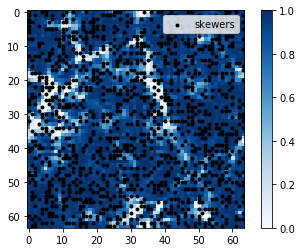

In [4]:
n_los = 1200
mock_lya1 = lya_survey(uni1,2,10,sm=0.5,n_skewers=n_los)
mock_lya1.select_skewers()
imshow(np.exp(-1*uni1.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya1.skewers_fin[::n][:,0],mock_lya1.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

In [5]:
skewers_fin1 = mock_lya1.skewers_fin
flux_obs1 = mock_lya1.vals_observed
inverse_covar1 = mock_lya1.inverse_covar
uni_final_true1 = uni1.final_true
uni_final_tau_RSD1 = uni1.final_tau_RSD
flux_true1 = exp(-uni_final_tau_RSD1[0])
flux_contrast1 = flux_obs1/flux_obs1.mean()-1

### Optimization

The quantity to be optimized:
$$\chi^2 = k_1(S_m(s) - s)^2 + k_2(R(s) - d)^T N^{-1} (R(s)-d)+k_3\sum clip(s,1,+\infty)+k_4\sum clip(s,0,0.4)$$
I add the $k_4\sum clip(s,0,0.4)$ term.

In [7]:
opt_recon1 = reconstruct_opt(uni1,mock_lya1,anneal_steps=[2.5,1.5,1,0.7],k=[6,6,0.7,0.6],clip=True)
opt_recon1.initmodel()
tau_opt_recon1,flux_los_opt_recon1 = opt_recon1.run_model()
flux_opt_recon1 = exp(-tau_opt_recon1[0])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 2011635.500000
  Number of iterations: 20
  Number of functions evaluations: 67
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 2000396.250000
  Number of iterations: 50
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1982630.625000
  Number of iterations: 60
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1954513.000000
  Number of iterations: 30
  Number of functions evaluations: 31
Total run time 14.269124


In [9]:
opt_recon2 = reconstruct_opt(uni1,mock_lya1,anneal_steps=[2.5,1.5,1,0.7],k=[6,6,0.7,0],clip=True)
opt_recon2.initmodel()
tau_opt_recon2,flux_los_opt_recon2 = opt_recon2.run_model()
flux_opt_recon2 = exp(-tau_opt_recon2[0])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1634148.000000
  Number of iterations: 23
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1622917.125000
  Number of iterations: 50
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1605817.875000
  Number of iterations: 60
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1580039.625000
  Number of iterations: 30
  Number of functions evaluations: 31
Total run time 15.700607


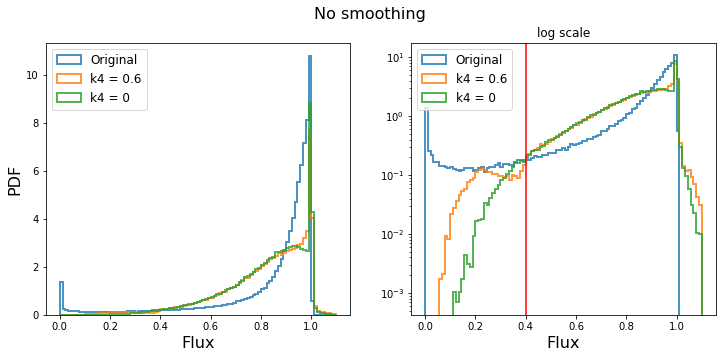

In [20]:
fig = figure(figsize=(12,5))

bins=linspace(0.0,1.1,100)
ax1 = fig.add_subplot(121)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(flux_true1.flatten(),label='Original',**h_list)
ax1.hist(flux_opt_recon1.flatten(),label='k4 = 0.6',**h_list)
ax1.hist(flux_opt_recon2.flatten(),label='k4 = 0',**h_list)

legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)

ax1 = fig.add_subplot(122)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(flux_true1.flatten(),label='Original',**h_list)
ax1.hist(flux_opt_recon1.flatten(),label='k4 = 0.6',**h_list)
ax1.hist(flux_opt_recon2.flatten(),label='k4 = 0',**h_list)

legend(loc=2,fontsize=12)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('log scale')
yscale('log')
suptitle('No smoothing',fontsize=16)
axvline(0.4,color='red')
show()

From the figure above, I find the PDF of optimized flux and original flux intersect at about flux=0.4, and there are fewer pixels at flux value below 0.4 compared to the original field. And this is why I try to add another term to penalize the optimization. With the fourth term, the PDF matches better at low flux values.

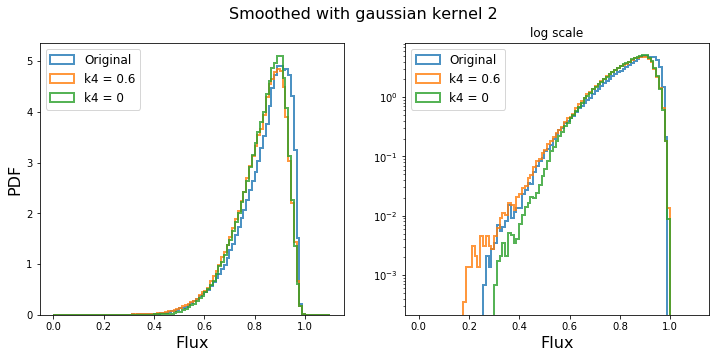

In [18]:
sigma = 2
fig = figure(figsize=(12,5))

bins=linspace(0.0,1.1,100)
ax1 = fig.add_subplot(121)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true1,sigma).flatten(),label='Original',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon1,sigma).flatten(),label='k4 = 0.6',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon2,sigma).flatten(),label='k4 = 0',**h_list)

legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)
# ax1.set_title('Smoothed with gaussian kernel %.2f (1.4<d_los>)'%sigma)

ax1 = fig.add_subplot(122)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true1,sigma).flatten(),label='Original',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon1,sigma).flatten(),label='k4 = 0.6',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_opt_recon2,sigma).flatten(),label='k4 = 0',**h_list)

legend(loc=2,fontsize=12)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('log scale')
yscale('log')
suptitle('Smoothed with gaussian kernel 2',fontsize=16)
show()

In [21]:
def flux_to_density(flux):
    tau = -np.log(flux)
    return (tau/0.226)**(1/1.5)

Text(0.5, 1.0, 'log scale')

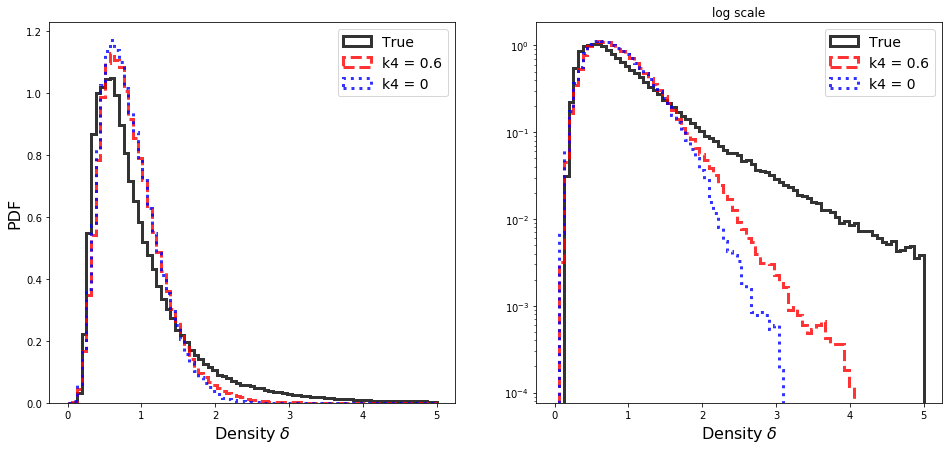

In [24]:
sigma = 2
density_opt1 = flux_to_density(np.clip(flux_opt_recon1,0.001,1))
density_opt2 = flux_to_density(np.clip(flux_opt_recon2,0.001,1))
density_true1 = uni_final_true1[0]
bins = np.linspace(0,5,80)
figure(figsize=(16,7))
subplot(121)

h_list = {'bins':bins,'histtype':'step','linewidth':3,'alpha':0.8,'density':True}
_=hist(ndimage.gaussian_filter(density_true1,sigma).flatten(),label='True',**h_list,color='k')
_=hist(ndimage.gaussian_filter(density_opt1,sigma).flatten(),label='k4 = 0.6',**h_list,linestyle='--',color='red')
_=hist(ndimage.gaussian_filter(density_opt2,sigma).flatten(),label='k4 = 0',**h_list,linestyle=':',color='blue')
legend(loc=1,fontsize=14)
xlabel(r'Density $\delta$',fontsize=16)
ylabel('PDF',fontsize=16)
subplot(122)

h_list = {'bins':bins,'histtype':'step','linewidth':3,'alpha':0.8,'density':True}
_=hist(ndimage.gaussian_filter(density_true1,sigma).flatten(),label='True',**h_list,color='k')
_=hist(ndimage.gaussian_filter(density_opt1,sigma).flatten(),label='k4 = 0.6',**h_list,linestyle='--',color='red')
_=hist(ndimage.gaussian_filter(density_opt2,sigma).flatten(),label='k4 = 0',**h_list,linestyle=':',color='blue')
legend(loc=1,fontsize=14)
xlabel(r'Density $\delta$',fontsize=16)
yscale('log')
title('log scale')

With k4=0.6, the optimization can reconstruct better at higher density.

In [25]:
def plot_eigenvectors(eigentruth,eigenstuff,
    color_pallete= ["r","b","g","v"],
    center_pallete = ["ro","bx","g*","v#"],
    labels = ["q","q1","q2"],binsize=20):

    plt.figure(figsize=(14,6))

    for ii in range(1,4):
        ax1 = plt.subplot(int("13"+str(ii)))
        for nn,entry in enumerate(eigenstuff):
            print(ii,nn)
            bins, hist_norm = make_hist_norm(np.ndarray.flatten(
                np.abs(np.sum(entry[ii]*eigentruth[ii],axis=3))),binsize=binsize)
            plt.plot(bins,hist_norm,drawstyle='steps-post',color=color_pallete[nn])
            bin_centers = (bins[:-1]+bins[1:])/2.
            hist_centers = hist_norm[:-1]
            plt.plot(bin_centers,hist_centers,center_pallete[nn],ms=5)
            
        plt.xlabel(r'$\cos\theta$',size=18)
        
        plt.title(r'$\hat{e}_'+str(ii)+'$',size=18)
        plt.plot(0.1*np.ones(len(bins)),color='k',linestyle='--')
        ax1.set_xlim([0.0,0.99])
        ax1.set_ylim([0.01,1.0])
        plt.minorticks_on()
        plt.yscale('log')
        plt.setp(ax1.get_xticklabels() + ax1.get_yticklabels(),fontname='Times New Roman',fontsize=18)
        if ii>1:
            plt.setp(ax1.get_yticklabels(), visible=False)
        if ii==1:

            #Create custom artists
            a1 = plt.Line2D((0,1),(0,0), color='r', marker='o')
            a2 = plt.Line2D((0,1),(0,0), color='b', marker='x')
            a3 = plt.Line2D((0,1),(0,0), color='g', marker='*')
#             pylab.rcParams['figure.figsize'] = (8.0, 4.0)

            #Create legend from custom artist/label lists
            ax1.legend([a1,a2,a3],
                      labels,loc=2,frameon=False,labelspacing=0.05,
                       bbox_to_anchor=(0,1),handletextpad=0.0,numpoints=1)
            

            leg = plt.gca().get_legend()
            ltext = leg.get_texts()
            plt.setp(ltext,fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)

In [26]:
a,b = eigen_stuff(uni_final_true1[0],
                  [density_opt1,
                   density_opt2],
                   kernel_sizes=[sigma]*4,pad = 1, rebin_size=64)

/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


0 (64, 64, 64)
1 (64, 64, 64)


1 0
0.9084743476277896
1 1
0.9036016876741588
2 0
0.8045054958301628
2 1
0.7957143189395453
3 0
0.8615213948324114
3 1
0.854806651148277


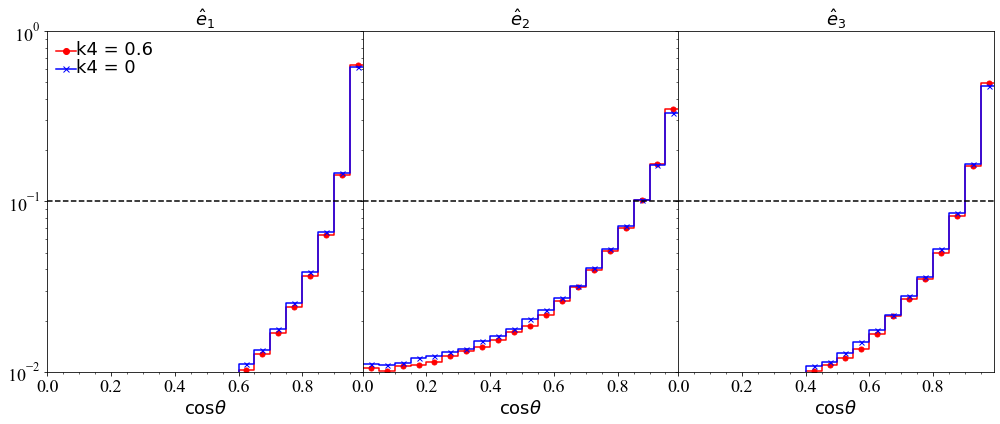

In [39]:
plot_eigenvectors(a,b,labels=["k4 = 0.6","k4 = 0"])

In [30]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [31]:
def classify(e,lam=0.052):
    return sum(e>lam,axis=3).flatten()

def choose_lam(e):
    # With bisection method to choose lambda threshold making the fraction of void at 22%
    a = 0
    b = 1
    lam = (a+b)/2
    label = classify(e,lam)
    while True:
        frac = len(label[label==0])/len(label)
        if frac-0.22<0 :
            a = lam
            lam = (a+b)/2
        else:
            b = lam
            lam = (a+b)/2
        label = classify(e,lam)
        
        if abs(frac-0.22)<0.001:
            print(frac)
            break
        
    return lam

In [32]:
sigma = 2
pad = 1
density_true_sm = ndimage.gaussian_filter(density_true1[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(density_true_sm)
true_label1 = classify(e_dm[0],choose_lam(e_dm[0]))

/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


0.2190132926051492


In [33]:
density_opt_sm = ndimage.gaussian_filter(density_opt1[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(density_opt_sm)
opt_label1 = classify(e_dm[0],choose_lam(e_dm[0]))

0.22056577489845927


In [34]:
density_opt_sm = ndimage.gaussian_filter(density_opt2[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(density_opt_sm)
opt_label2 = classify(e_dm[0],choose_lam(e_dm[0]))

0.22060773387935953


Text(0, 0.5, 'True')

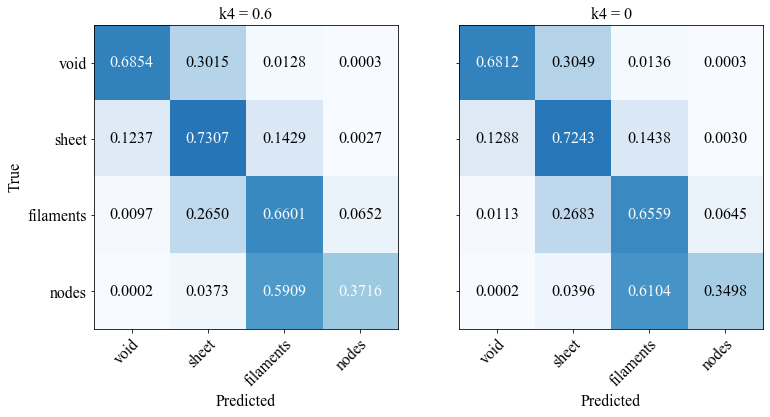

In [40]:
fig, axes = plt.subplots(1,2,sharey='row',figsize=(12,6.5))    

y_true = true_label1
titles = ['k4 = 0.6','k4 = 0']
y = [opt_label1,opt_label2]
classes=np.array(["void","sheet","filaments","nodes"])
for i,ax in enumerate(axes):

#     t = titles[i]
    y_pred = y[i]
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues',vmin=0,vmax=1)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
          )
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_xticklabels() + ax.get_yticklabels(),fontname='Times New Roman',fontsize=16)
    ax.set_xlabel('Predicted',family='Times New Roman',fontsize=16)
    ax.set_title(titles[i],family='Times New Roman',fontsize=16)
    normalize = True
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",family='Times New Roman',fontsize=16)
axes[0].set_ylabel('True',family='Times New Roman',fontsize=16)

With k4, the optimization performs silghtly better in cosmic web classification.